In [1]:
%matplotlib inline
from functools import partial
from io import StringIO

import sys
sys.path.append('../cholla-vis')
sys.path.append('/ix/eschneider/mabruzzo/packages/gascloudutil/gascloudutil')

import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import unyt

In [2]:
%load_ext autoreload
%autoreload 1
%aimport ICs
%aimport utils

# Give an overview on photoelectric heating

We are using a formula 

$$
\Gamma_{\rm pe}= \begin{cases}
  \left(\frac{n_{\rm avg}}{{\rm cm}^3}\right) 10^{-26}\ {\rm erg}\ {\rm s}^{-1}, & T<10^4\, {\rm K} \\
  0 \ {\rm erg}\ {\rm s}^{-1}, & T>10^4\, {\rm K} \\
\end{cases}
$$

where we add $n\Gamma_{\rm pe}$ to the volumetric cooling rate

## First Attempt
Initially we just tried estimating the average number density of gas at the center of a Milky Way-like disk

In [3]:
def estimate_central_ndens(thickness = 1.0 * unyt.pc, mu = 0.6):
    # this function estimate the number density of gas
    M_d = 0.15 * unyt.unyt_quantity(6.5e10, 'Msun')
    R_d = 5.4 * unyt.kpc
    Sigma0 = M_d / (2 * np.pi * R_d * R_d)
    return ((Sigma0/ (mu*unyt.mh_cgs)).to('cm**-2') / thickness).to('cm**-3')
estimate_central_ndens(thickness = 1.0 * unyt.pc, mu = 0.6)

unyt_quantity(3586.3676168, 'cm**(-3)')

## More careful attempt

Ok, now we are a little more careful. We loosely follow what was done in [Kim & Ostriker 2017](https://iopscience.iop.org/article/10.3847/1538-4357/aa8599/pdf).

Essentially we want to estimate $\Sigma_{\rm FUV}$, which we can then translate to a photoelectric heating rate

#### Following Cell is Hidden because it encodes a data-table

Essentially, we used [Webplot digitizer](https://apps.automeris.io/wpd4/) to extract data from Fig 5 of Kim & Ostriker

The long and the short of this is that 
$$
\int_0^{40\ {\rm Myr}} \Psi_{\rm FUV}\ {\rm d}t \approx4300\ L_\odot\ {\rm Myr}\ M_\odot^{-1},
$$
where $\Psi_{\rm FUV}$ is the specific FUV luminosity.

The integrated number is mostly relevant when we consider star formation in the continuum limit.
- In the continuum limit of SNe, I also confirmed that accounting for mass losses due to SNe (assuming each SNe expels $10 M_\odot$, has minimal impact on the integral
- As in KO2017, we assume a fully sampled Kroupa IMF

In [4]:
# point with a value of zero was inserted by me
lum_to_mass_csv_f = StringIO("""
0.0, 460.51169799026695
0.1437850333832209, 460.51169799026695
0.3075840647978909, 470.1877379813077
0.46573485374998747, 478.63228197348866
0.6131026343644415, 486.78894378411803
0.7556779668288325, 495.0287715583067
0.9006495233682541, 504.0938615862767
0.9981758432220467, 512.691942741952
1.0508927728727464, 522.0864979332532
1.1036097025234444, 532.184765123903
1.1510549392090734, 541.2626499154976
1.216951101272448, 549.472623241229
1.3250208070563811, 557.3776547005763
1.4190326649334608, 565.6579992262426
1.474678312898087, 574.2589236627232
1.527395242548785, 582.0779458777056
1.5727903764146642, 590.4345258699681
1.6578563310782926, 599.2869029526805
1.735334242837654, 608.2325751868218
1.813057921168813, 618.4003113825354
1.8700552852783279, 629.2266498340493
1.9154504191442072, 638.5860194253834
1.9645730126823597, 648.9945596339276
2.025277355916497, 661.6208588707215
2.047242743270955, 673.5165237930403
2.0736012080963047, 681.917085785262
2.104352750392545, 690.9969253324102
2.1263181377470026, 699.5538677689317
2.155312449054888, 708.8164769603552
2.1790350673977024, 718.0263077518275
2.2317519970484003, 728.0102217425831
2.282272387963655, 740.0026470648124
2.333591520237251, 751.4806162663059
2.3964924022068352, 762.5507523772678
2.484793259371756, 773.2764961006699
2.555375370737412, 781.1893465822321
2.693025131492016, 788.4414896866283
2.7890452533557895, 795.9058633940025
2.8986211571297407, 781.1580704933722
2.920366890610655, 771.8602757019812
2.9697890121581842, 763.7236057095151
2.996147476983534, 754.557756918002
3.0122554277101354, 744.7917981714891
3.037712748438894, 733.7549475834178
3.0692323112720032, 721.4449086577531
3.0949917200785944, 709.0099977601759
3.1213501849039442, 696.108611105455
3.1542982659356316, 683.3831524505712
3.1575930740387985, 672.7688297937326
3.199918685825658, 662.0845870343946
3.2281019674466087, 650.6546802142086
3.257096278754492, 640.1693714239173
3.2860905900623774, 630.6340738327463
3.3064584947001467, 620.5901843875007
3.3402718788700394, 610.1091405184175
3.365165984538427, 601.0781698601129
3.3900600902068128, 591.8908187575086
3.417882914189125, 583.089531876769
3.444241379014475, 575.2167538840586
3.4738946519429916, 566.9921198916741
3.5002531167683415, 558.7235038993301
3.556997034100691, 549.941764574128
3.570043142953642, 540.0471473711684
3.605686976069739, 530.7069699252713
3.679271023707175, 520.4151819348008
3.711120835371137, 510.65117794384156
3.7825083442731255, 500.4473539532895
3.7956875766858005, 490.6540286290241
3.948093572022117, 466.31732198489135
3.997769140346813, 455.93756999450227
4.0135842192420235, 447.3874692024191
4.098809922177319, 436.7027753456456
4.15064823633384, 425.36128362281363
4.203365165984538, 415.3333876320987
4.254031992815488, 406.4627069292012
4.336834846963807, 396.68182095845964
4.388753035256162, 386.8369611695954
4.478811123409439, 377.32707540062313
4.573262289033607, 367.32850074321436
4.652337683509655, 358.64938608458397
4.731413077985705, 350.4394127588524
4.814881549932645, 341.6195557003523
4.870893287686512, 332.39213210889625
4.91592233176315, 324.5584492272608
4.992801187503753, 314.5501007920833
5.081507559512142, 303.38092828960464
5.179506980016644, 293.75150170023016
5.258582374492693, 285.42424304127394
5.348041406627214, 276.85885961486133
5.447484705741031, 267.9878235018631
5.5559599263684305, 258.64108463872265
5.66913543268147, 249.38210473121194
5.750607051232549, 241.4031479709231
5.829682445708597, 233.8968866445399
5.895578607771972, 226.57144020687838
5.97465400224802, 219.66626621327202
6.049336319253175, 212.00362444258928
6.128411713729225, 204.1846022276069
6.219787725123769, 196.1270998350675
6.296946140339793, 187.83929169728685
6.4332912902091, 179.83616705015186
6.55600458756267, 171.46199425790564
6.709649656031802, 163.23397703475496
6.884021038722574, 154.64830398775962
7.0685302925000215, 146.83207428071114
7.256554008254183, 139.39618415426287
7.469555507342832, 132.30544800844746
7.708322120533502, 125.49680593682967
7.991076561387251, 117.91590848930355
8.281019674466094, 111.45455285892263
8.57096278754494, 105.72889613695133
8.860905900623782, 100.22714777840929
9.150849013702626, 95.17321614672517
9.44079212678147, 90.37517978753147
9.730735239860312, 85.7370779736442
10.020678352939157, 81.38685834130854
10.310621466018002, 77.35650779958576
10.600564579096844, 73.48609180316953
10.890507692175689, 70.03150562454994
11.18045080525453, 66.7688409002983
11.470393918333375, 63.92200599384341
11.76033703141222, 61.13914490551099
12.050280144491062, 58.67615290779156
12.340223257569907, 56.53303000068502
12.630166370648752, 54.51785472982351
12.920109483727593, 52.6306270952075
13.210052596806438, 50.839360187775014
13.499995709885283, 49.14405400752662
13.789938822964125, 47.4807347363394
14.07988193604297, 45.84940237421358
14.369825049121811, 44.28204383021023
14.659768162200656, 42.906606740574716
14.949711275279501, 41.56315656000061
15.239654388358343, 40.21970637942627
15.529597501437188, 39.036190744158375
15.819540614516033, 37.98062274513575
16.109483727594874, 37.21293692766483
16.39942684067372, 36.38127729207122
16.689369953752564, 35.6135914746003
16.979313066831406, 34.84590565712915
17.26925617991025, 34.11020674871952
17.559199292989092, 33.37450784030989
17.849142406067937, 32.638808931900144
18.139085519146782, 31.999070750674264
18.429028632225624, 31.327345660387095
18.71897174530447, 30.655620570100155
19.008914858383314, 30.04786929793545
19.298857971462155, 29.47210493483226
19.588801084541, 28.864353662667668
19.878744197619845, 28.25660239050319
20.168687310698687, 27.648851118338712
20.45863042377753, 27.1370605733581
20.748573536856373, 26.65725693743866
21.038516649935218, 26.145466392457934
21.328459763014063, 25.537715120293456
21.618402876092905, 25.153872211557882
21.90834598917175, 24.706055484699846
22.198289102250595, 24.130291121596656
22.488232215329436, 23.810422030983773
22.77817532840828, 23.330618395064334
23.068118441487126, 22.818827850083608
23.358061554565968, 22.59491948665459
23.648004667644813, 21.987168214489998
23.937947780723654, 21.827233669183556
24.2278908938025, 21.21948239701908
24.517834006881344, 20.99557403359006
24.807777119960186, 20.51577039767062
25.097720233039034, 20.38782276142547
25.387663346117876, 19.81205839832228
25.677606459196717, 19.748084580199702
25.96754957227556, 19.14033330803511
26.257492685354407, 19.108346398973822
26.54743579843325, 18.724503490238362
26.83737891151209, 18.404634399625365
27.12732202459094, 18.404634399625365
27.41726513766978, 17.892843854644752
27.70720825074862, 17.700922400277022
27.99715136382747, 17.509000945909293
28.28709447690631, 16.997210400928566
28.577037589985153, 16.997210400928566
28.866980703064, 16.965223491867278
29.156923816142843, 16.325485310641398
29.446866929221684, 16.29349840158011
29.736810042300533, 16.29349840158011
30.026753155379375, 15.877668583783475
30.316696268458216, 15.589786402231766
30.606639381537065, 15.589786402231766
30.896582494615906, 15.109982766312328
31.186525607694747, 14.88607440288331
31.47646872077359, 14.88607440288331
31.766411833852437, 14.88607440288331
32.05635494693128, 14.31031003978012
32.34629806001012, 14.182362403534967
32.63624117308897, 14.182362403534967
32.92618428616781, 13.766532585738219
33.21612739924665, 13.47865040418651
33.5060705123255, 13.47865040418651
33.79601362540434, 13.28672894981878
34.08595673848318, 12.774938404838053
34.37589985156203, 12.774938404838053
34.66584296464087, 12.774938404838053
34.955786077719715, 12.391095496102594
35.24572919079856, 12.07122640548971
35.535672303877405, 12.07122640548971
35.825615416956246, 12.07122640548971
36.115558530035095, 11.815331132999404
36.405501643113936, 11.367514406141254
36.69544475619278, 11.367514406141254
36.98538786927163, 11.367514406141254
37.27533098235047, 11.367514406141254
37.56527409542931, 11.143606042712236
37.85521720850815, 10.663802406792797
38.145160321587, 10.663802406792797
38.43510343466584, 10.663802406792797
38.72504654774468, 10.663802406792797
39.01498966082353, 10.471880952425067
39.30493277390237, 9.960090407444454
39.594875886981214, 9.960090407444454
39.84528130282204, 9.960090407444454
""")

snr_rate_f = StringIO("""
0.0, 0.0000028567937936513355
2.7984589907934136, 0.0000028567937936513355
3.1066502718282685, 0.000004119866612994601
3.268856209215034, 0.000012961376348397677
3.3160433910002745, 0.000026171696398325905
3.365165984538427, 0.000038107552279530166
3.2992698224750523, 0.0000036386960151494133
3.417882914189125, 0.00010173949973383927
3.40470368177645, 0.00008936868958656346
3.40470368177645, 0.00008076776515008287
3.40470368177645, 0.00007216684071360228
3.40470368177645, 0.00006356591627712169
3.40470368177645, 0.000054964991840641096
3.40470368177645, 0.0000476206959744254
3.450391687473722, 0.00016812486001099554
3.4310621466018, 0.00015571867809655688
3.4310621466018, 0.0001471177536600763
3.4310621466018, 0.0001385168292235957
3.4310621466018, 0.0001299159047871151
3.4310621466018, 0.00012131498035063441
3.4310621466018, 0.00011336564109873566
3.476750152299072, 0.0002352120706155446
3.4574206114271497, 0.00022251546787597782
3.4574206114271497, 0.00021391454343949723
3.4574206114271497, 0.00020531361900301653
3.4574206114271497, 0.00019671269456653594
3.4574206114271497, 0.00018811177013005535
3.4574206114271497, 0.00018021828103683497
3.493916947339171, 0.0003003405159113658
3.483779076252498, 0.0002885303554339007
3.483779076252498, 0.00027992943099742
3.483779076252498, 0.0002713285065609394
3.483779076252498, 0.0002627275821244588
3.483779076252498, 0.0002541266576879781
3.4679639973572876, 0.00024720123801185085
3.5233167734905226, 0.000366273776314297
3.5101375410778477, 0.00035376334077032515
3.5101375410778477, 0.00034516241633384456
3.5101375410778477, 0.00033656149189736386
3.5101375410778477, 0.00032796056746088327
3.5101375410778477, 0.0003193596430244027
3.5101375410778477, 0.0003111869031377901
3.55582554677512, 0.00043438862983852917
3.5364960059031976, 0.0004217888340406719
3.5364960059031976, 0.0004131879096041913
3.5364960059031976, 0.0004045869851677106
3.5364960059031976, 0.00039598606073123
3.5364960059031976, 0.00038738513629474943
3.5364960059031976, 0.00037878421185826873
3.5821840116004697, 0.0005027790108122418
3.5628544707285474, 0.0004901494282630892
3.5628544707285474, 0.0004815485038266086
3.5628544707285474, 0.00047294757939012803
3.5628544707285474, 0.00046434665495364734
3.5628544707285474, 0.00045574573051716675
3.5628544707285474, 0.00044714480608068615
3.6102997074141765, 0.0005461485206980107
3.6419298652045953, 0.0005352966656238837
3.6463229426754875, 0.0005265032273828675
3.6366581722395264, 0.0005184431186495898
3.5101375410778477, 0.0005146117977642484
3.9179184969053136, 0.000534113359053381
3.826439118982041, 0.0005225611370161472
4.0335413426097855, 0.0005427882028175243
4.292983946390725, 0.0005382252448534953
4.451134735342823, 0.0005510875363971413
4.530210129818871, 0.0005616823114984425
4.615310316255, 0.0005686747513649838
4.610603447536187, 0.0005765775488179839
4.81751739641518, 0.000560978599499094
4.8860494049610885, 0.0005717297550446947
4.920315409234043, 0.0005806825354808497
4.980354134669561, 0.0005897612890526903
5.065286965773465, 0.0005991441157106691
5.2203367588637555, 0.0006054504382030145
5.440895089534694, 0.0006053124554580441
5.421126240915681, 0.0005967115310215635
5.5054733283568, 0.0006197385514446867
5.568733643937639, 0.0006305678972124372
5.645173191931152, 0.0006407113014858735
5.813867366813387, 0.0006447203274215554
5.9592782310998995, 0.0006317668139520679
6.027370931898718, 0.000620803893221478
6.0537293967240675, 0.0006119586243407792
6.083382669652586, 0.000603015617682393
6.132804791200115, 0.0005943658243570688
6.162458064128634, 0.0005852273421433082
6.207487108205273, 0.0005742970006719474
6.263583328218196, 0.0005603230045595301
6.306770659047423, 0.0005468652644010509
6.3414759710674655, 0.0005346480421901408
6.373325782731429, 0.0005243367066441328
6.486247842267302, 0.0005150382898850656
6.5999353622715855, 0.000504794580983215
6.655581010236213, 0.0004953683153129308
6.7197875271184735, 0.0004838469526645293
6.8231938122025415, 0.00047377244327214806
7.1212472221507195, 0.00048052796910893884
7.353680957428802, 0.00047612088386049425
7.455121109938478, 0.00046713295731438324
7.51662419453096, 0.00045857547189020803
7.630844208774143, 0.00044893201115839645
7.8100817695865175, 0.0004402789599071492
8.011352303560596, 0.00043281279613058656
8.273112135018492, 0.0004245366618476513
8.420719538040446, 0.00041773411252061675
8.702755111671685, 0.0004102278511942336
8.99269822475053, 0.00040216004190877445
9.282641337829372, 0.0003992812200932583
9.572584450908217, 0.00039522954494549474
9.862527563987062, 0.0003886189170728277
10.152470677065903, 0.00038268356839145476
10.442413790144748, 0.0003769259247604223
10.732356903223593, 0.0003714170681998665
11.022300016302434, 0.00036622808072992363
11.31224312938128, 0.00036125233932038944
11.602186242460125, 0.0003557790237699017
11.892129355538966, 0.0003514430205415934
12.182072468617811, 0.00034710701731328485
12.472015581696652, 0.00034259330903463597
12.761958694775497, 0.0003380085187358508
13.051901807854343, 0.0003338146795478148
13.341844920933184, 0.0003283413639973272
13.631788034012029, 0.00032254817935622657
13.921731147090874, 0.0003182477171379863
14.211674260169715, 0.0003145514520909037
14.50161737324856, 0.0003110328920941616
14.791560486327402, 0.00030758541411755576
15.081503599406247, 0.0003040313131107455
15.371446712485092, 0.0003006193761442078
15.661389825563933, 0.0002972074391776701
15.951332938642778, 0.00029397320726147285
16.241276051721623, 0.0002907745163553436
16.531219164800465, 0.0002876824484794187
16.82116227787931, 0.00028469700363369826
17.111105390958155, 0.00028174709979804575
17.401048504036996, 0.0002790815240429381
17.69099161711584, 0.0002763804072777624
17.980934730194683, 0.0002738925365729952
18.270877843273528, 0.0002714757478883643
18.560820956352373, 0.00026916558223393774
18.850764069431214, 0.00026692649859964737
19.14070718251006, 0.00026500728405596976
19.430650295588904, 0.00026294590547201995
19.720593408667746, 0.00026070682183772947
20.01053652174659, 0.0002585743612336434
20.300479634825436, 0.0002564419006295573
20.590422747904277, 0.0002544160630556755
20.880365860983122, 0.0002524613075019299
21.170308974061964, 0.00025047101093811613
21.46025208714081, 0.000248622878414575
21.750195200219654, 0.0002467036638708974
22.040138313298495, 0.0002448910723574242
22.33008142637734, 0.00024311402185401914
22.620024539456185, 0.00024133697135061407
22.909967652535027, 0.00023959546185727703
23.199910765613872, 0.00023788949337400823
23.489853878692717, 0.00023618352489073932
23.77979699177156, 0.00023451309741753855
24.069740104850403, 0.00023291375196447394
24.359683217929245, 0.00023131440651140943
24.64962633100809, 0.00022975060206841295
24.939569444086935, 0.00022818679762541647
25.229512557165776, 0.00022669407520255615
25.519455670244625, 0.00022520135277969582
25.809398783323466, 0.00022374417136690374
26.099341896402308, 0.0002223225309641797
26.38928500948115, 0.00022090089056145542
26.679228122559998, 0.00021944370914866334
26.96917123563884, 0.00021809315076607545
27.25911434871768, 0.00021674259238348766
27.54905746179653, 0.0002154275750109678
27.83900057487537, 0.00021407701662838011
28.128943687954212, 0.0002128330812759964
28.41888680103306, 0.0002115891459236129
28.708829914111902, 0.00021023858754102502
28.998773027190744, 0.0002091012752188457
29.288716140269592, 0.00020778625784632595
29.578659253348434, 0.00020668448653421488
29.868602366427275, 0.00020544055118183117
30.158545479506124, 0.00020433877986972022
30.448488592584965, 0.0002030948445173365
30.738431705663807, 0.0002020641552253616
31.028374818742655, 0.00020089130189311427
31.318317931821497, 0.00019982507159107122
31.60826104490034, 0.00019897208734943677
31.892121435327176, 0.00019379130165104801
32.18814727105803, 0.00018998021180220692
32.47809038413687, 0.00018894952251023213
32.76803349721571, 0.00018777666917798468
33.05797661029456, 0.00018656827483566933
33.3479197233734, 0.00018539542150342188
33.63786283645224, 0.0001842936501913107
33.92780594953109, 0.00018319187887919964
34.21774906260993, 0.0001820190255469523
34.507692175688774, 0.00018102387726504532
34.79763528876762, 0.00017988656494286623
35.087578401846464, 0.00017882033464082308
35.377521514925306, 0.00017786072736898422
35.667464628004154, 0.00017675895605687327
35.957407741082996, 0.00017576380777496639
36.24735085416184, 0.00017480420050312764
36.537293967240686, 0.0001738445932312889
36.82723708031953, 0.00017288498595945014
37.11718019339837, 0.00017188983767754326
37.40712330647722, 0.00017100131242584068
37.69706641955606, 0.00017007724616406995
37.9870095326349, 0.00016918872091236747
38.27695264571374, 0.00016826465465059686
38.56689575879259, 0.00016737612939889438
38.85683887187143, 0.0001664876041471918
39.14678198495027, 0.00016563461990555734
39.43672509802912, 0.00016478163566392278
39.72666821110796, 0.00016392865142228843
39.91117746488541, 0.00016340738327462294
""")

In [5]:
def load_krouppa_data(lum_to_mass=True):
    f = lum_to_mass_csv_f if lum_to_mass else snr_rate_f
    f.seek(0)
    tmp = np.loadtxt(f, delimiter=',')
    age = unyt.unyt_array(tmp[:,0], 'Myr')
    if lum_to_mass:
        y = unyt.unyt_array(tmp[:,1], 'Lsun/Msun')
    else:
        y = unyt.unyt_array(tmp[:,1], '1/Myr/Msun')
    return age, y

class SpecificSNRate:
    def __init__(self, age_grid, specific_snr):
        ages = age_grid.to('Myr').ndview
        specific_snr = specific_snr.to('1/Myr/Msun').ndview
        assert ages[0] == 0.0
        if ages[-1] < 40.0:
            ages = np.append(ages, [40.0])
            specific_snr = np.append(specific_snr, [specific_snr[-1]])
        self.ages_Myr = ages
        self.specific_snr = specific_snr

    def value(self, age_Myr):
        return np.interp(age_Myr, xp = self.ages_Myr, fp=self.specific_snr,
                         left=np.nan, right=np.nan)

    def _cumulative_value(self, age_Myr):
        assert age_Myr < 40.0
        i = np.searchsorted(self.ages_Myr, age_Myr, 'right')
        if i < 2:
            tot = 0.0
        else:
            tot = integrate.trapezoid(
                y=self.specific_snr[:i], x=self.ages_Myr[:i]
            )
        if self.ages_Myr[i-1] < age_Myr:
            x = [self.ages_Myr[i-1], age_Myr]
            y = [self.specific_snr[i-1], self.value(age_Myr)]
            tot += integrate.trapezoid(y=y, x=x)
        return tot

    def cumulative_value(self, age_Myr):
        if np.ndim(age_Myr) == 0:
            return self._cumulative_value(age_Myr)
        age_Myr = np.asanyarray(age_Myr)
        assert age_Myr.ndim == 1
        return np.array([
            self._cumulative_value(elem) for elem in age_Myr
        ])

def load_SpecificSNRate():
    age_ssnr, specific_snr = load_krouppa_data(False)
    return SpecificSNRate(age_ssnr, specific_snr)

class SpecificFUVLuminosityRatio:
    def __init__(self, age_grid, ltom_ratio):
        self.ages_Myr = age_grid.to('Myr').ndview
        self.ltom_ratio = ltom_ratio.to('Lsun/Msun').ndview
    def __call__(self, age_Myr):
        return np.interp(age_Myr, xp = self.ages_Myr, 
                         fp=self.ltom_ratio,
                         left=np.nan, right=0.0)

age, ltom_ratio = load_krouppa_data(True)
ltom_ratio_functor = SpecificFUVLuminosityRatio(age, ltom_ratio)
specific_snr_functor = load_SpecificSNRate()

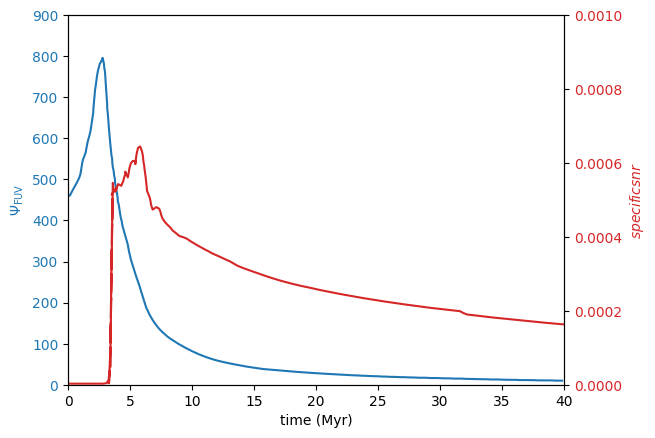

In [6]:
def plot_ko17fig5(age_arr, ltom_ratio_arr, specific_snr_functor):
    # this just replicates table 5
    fig,ax1 = plt.subplots(1,1)

    prop_l = [
        (age_arr.to('Myr').ndview, ltom_ratio_arr,
         'tab:blue', (0.0, 900), r'$\Psi_{\rm FUV}$'),
        (specific_snr_functor.ages_Myr, specific_snr_functor.specific_snr,
         'tab:red', (0.0,0.001), r'$specific snr$'),
    ]
    for i, (x, y, color, ylim, ylabel) in enumerate(prop_l):
        ax = ax1 if i == 0 else ax1.twinx()
        ax.set_ylabel(ylabel, color=color)
        ax.plot(x, y, color=color)
        ax.tick_params(axis='y', labelcolor=color)
        ax.set_ylim(*ylim)
    ax1.set_xlim(0,40)
    ax1.set_xlabel('time (Myr)')

plot_ko17fig5(age, ltom_ratio, specific_snr_functor)

In [7]:
# here, we consider the cumulative amount of FUV Luminosity per solar mass
# over a 40 Myr period (assuming a continuum sampled Krouppa IMF)
# - we confirm that losses from SN (in the continuous limit) don't
#   significantly impact things!

def integrated_ltom_ratio(age_arr, ltom_ratio_arr, specific_snr_functor):
    # first, we compute the integrated ltom ratio ignoring any destruction
    # of star particles
    integrated_ltom_ratio = integrate.trapezoid(
        y = ltom_ratio_arr, x=age_arr
    )

    # next, we compute the integrated ltom ratio accounting for particle
    # destruction of stars from SN
    # -> remaining mass frac is the remaining fraction of mass in a
    #    cluster at a given time assuming that
    #    a. supernovae are continuous
    #    b. each supernova ejects 10 Msun
    remaining_mass_frac = (
        1.0 - 10.0*specific_snr_functor.cumulative_value(age_arr)
    )/1.0
    # the following line computes the actual integral
    integrated_ltom_ratio_with_losses = integrate.trapezoid(
        y = ltom_ratio_arr * remaining_mass_frac, x = age_arr
    )

    print("integrated Psi_FUV ratio (w/out losses):",
          integrated_ltom_ratio)
    print("integrated Psi_FUV ratio (w/ losses):   ",
          integrated_ltom_ratio_with_losses)
integrated_ltom_ratio(age, ltom_ratio, specific_snr_functor)

integrated Psi_FUV ratio (w/out losses): 4332.454205431209 Lsun*Myr/Msun
integrated Psi_FUV ratio (w/ losses):    4266.724843123504 Lsun*Myr/Msun


#### Putting things together in the Continuum Limit of Star Formation

In [8]:
def _SigmaSFR0(Rgas_scale_length, total_SFR, k_s_power = 1.4):
    # we use the Kennicutt–Schmidt law to determine the distribution of particles with respect to r_cyl
    #   Sigma_SFR(r_cyl) = a * Sigma_gas^k_s_power,
    # where `a` is some arbitrary normalization constant and k_s_power is usually 1.4. We can combine
    # this with the formula for the gas surface density,
    #   Sigma_gas(r_cyl) = Sigma_gas0 * exp(-r_cyl / Rgas_scale_length),
    # to get a more detailed formula for star-formation surfacte denstiy:
    #   Sigma_SFR(r_cyl) = a * Sigma_gas^k_s_power * exp(-k_s_power * r_cyl / Rgas_scale_length).
    #
    # The incremental rate of star-formation dSFR in the disk between r_cyl and (r_cyl + dr_cyl) is
    # given by
    #   dSFR = a * Sigma_gas^k_s_power * exp(-k_s_power * r_cyl / Rgas_scale_length) * (2*pi*r_cyl*dr_cyl)
    # In principle, we could compute `a` by choosing a value that gives the desired global SFR rate
    # when we integrate dSFR from r_cyl = 0 to infinity. But that's not really necessary. Instead,
    # we consolidate all constants into a variable b:
    #   dSFR = b * r_cyl * exp(-k_s_power * r_cyl / Rgas_scale_length) * dr_cyl
    #
    # the integral of dSFR from 0 to infinity, divided by b is:

    SFR_div_b = 2*np.pi*Rgas_scale_length**2/k_s_power**2
    b = (total_SFR/SFR_div_b)
    return b.to('Msun/Myr/kpc**2')

class SigmaSFR:
    def __init__(self, gas_rd, total_SFR, k_s_power = 1.4):
        # gas_rd is the scale length of an exponential gas disk
        # total_SFR is the total star formation rate over entire disk
        self.Sigma0 = _SigmaSFR0(
            Rgas_scale_length=gas_rd, total_SFR=total_SFR, k_s_power = k_s_power
        )
        self.exponential_denom = gas_rd / k_s_power

    def __call__(self, r_cyl):
        return self.Sigma0 * np.exp(-r_cyl / self.exponential_denom)

sigma_sfr = SigmaSFR(
    gas_rd = unyt.unyt_quantity(5.4, 'kpc'),
    total_SFR = unyt.unyt_quantity(2, 'Msun/year')
)
sigma_sfr_Rg3 = SigmaSFR(
    gas_rd = unyt.unyt_quantity(3.0, 'kpc'),
    total_SFR = unyt.unyt_quantity(2, 'Msun/year')
)

/ix/eschneider/mabruzzo/envs-ondemand/py_310/lib/python3.10/site-packages/unyt/array.py:1906: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


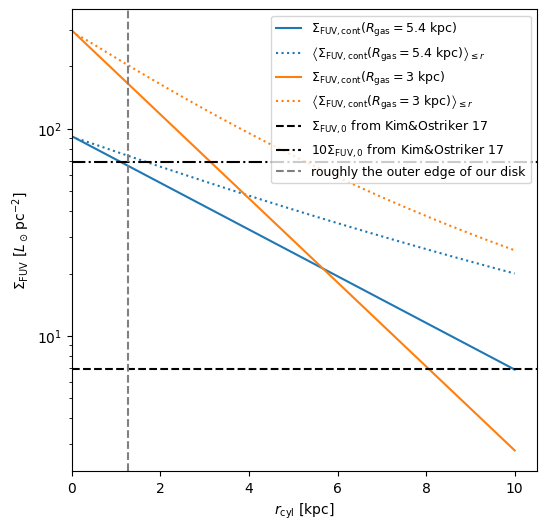

In [9]:
def show_continuum_FUV(integrated_psi):
    def get_avg_internal_FUV(radii, SigmaFUV):
        y, x = SigmaFUV*2*np.pi * radii, radii
        initial = y[0]*x[0] * 0
        tmp = integrate.cumulative_trapezoid(
            y=y.ndview, x = x.ndview, initial = 0.0
        ) * y.uq * x.uq
        avg_internal_FUV = tmp / (np.pi * np.square(radii))
        return avg_internal_FUV.to('Lsun/pc**2')

    fig,ax = plt.subplots(1,1, figsize =(6,6))
    radii = np.linspace(0.0, 10.0, num = 101) *unyt.kpc

    pairs = [(sigma_sfr, '5.4'), (sigma_sfr_Rg3, '3')]
    
    for sigma_sfr_fn, Rg_str in pairs:
        label_prefix = r'\Sigma_{\rm FUV,cont}(R_{\rm gas}='
        label = label_prefix + Rg_str + r'\ {\rm kpc})'

        SigmaFUV = (sigma_sfr_fn(radii)* integrated_psi).to('Lsun/pc**2')
        line, = ax.plot(radii, SigmaFUV, label='$' + label + '$')

        avgSigmaFUV = get_avg_internal_FUV(radii, SigmaFUV)
        label = r'\left\langle' + label + r'\right\rangle_{\leq r}'

        line, = ax.plot(
            radii, avgSigmaFUV, label='$' + label + '$',
            ls = ':', color = line.get_color()
        )
    ax.axhline(6.9, color = 'k', ls = '--',
               label = r"$\Sigma_{{\rm FUV},0}$ from Kim&Ostriker 17")
    ax.axhline(69, color = 'k', ls = '-.',
               label=r"$10\Sigma_{{\rm FUV},0}$ from Kim&Ostriker 17"
               )
    ax.axvline(1.27, color = 'gray', ls = '--',
               label = "roughly the outer edge of our disk")
    ax.set_xlabel(r'$r_{\rm cyl}$ [kpc]')
    ax.set_ylabel(r'$\Sigma_{\rm FUV}\ [L_\odot\, {\rm pc}^{-2}]$')
    ax.set_xlim(0.0, ax.get_xlim()[1])
    ax.set_yscale('log')
    ax.legend(fontsize= 9, loc = 'upper right')

show_continuum_FUV(unyt.unyt_quantity(4300, 'Lsun*Myr/Msun'))

### Now looking at the star particles

In [10]:
props = utils.concat_particles(
    0,
    '/ix/eschneider/mabruzzo/hydro/galactic-center/708_cube_v2/raw/0/'
)[1]

In [11]:
props

{'age': array([-39990.39204959, -39921.26004186, -39905.6587308 , ...,
        999744.14730962, 999764.40791394, 999790.40805205]),
 'mass': array([ 250.47326442, 1420.79479575,  113.77574415, ...,  160.71338764,
         120.19304716,  107.3963591 ]),
 'particle_IDs': array([     0,      5,      8, ..., 119169, 119172, 119176]),
 'pos_x': array([-0.74922778, -0.57451185, -0.41938619, ...,  0.13495367,
         0.94496535,  0.27183008]),
 'pos_y': array([-0.82125576, -0.99409146, -0.80153156, ...,  0.61865201,
         0.35180424,  0.33228999]),
 'pos_z': array([-0.00324939,  0.00418497,  0.00268998, ..., -0.00426899,
         0.0011655 ,  0.00138664]),
 'vel_x': array([ 8.61215305e-05,  1.03217145e-04,  8.93850697e-05, ...,
        -7.66559886e-05, -3.79934973e-05, -4.65302018e-05]),
 'vel_y': array([-7.85682685e-05, -5.96519295e-05, -4.67690425e-05, ...,
         1.67218518e-05,  1.02052603e-04,  3.80640668e-05]),
 'vel_z': array([0., 0., 0., ..., 0., 0., 0.])}

In [12]:
props['age'].max()

999989.5911833915

0.5 0.7853981633974483 kpc**2
[51.11523382 51.85702308 52.33416137 ... 77.37574091 76.91052136
 76.27677474] Lsun/pc**2
None 5.067074790974977 kpc**2
[69.66754409 69.80205134 69.61316362 ... 85.19861625 85.26642634
 85.73257994] Lsun/pc**2


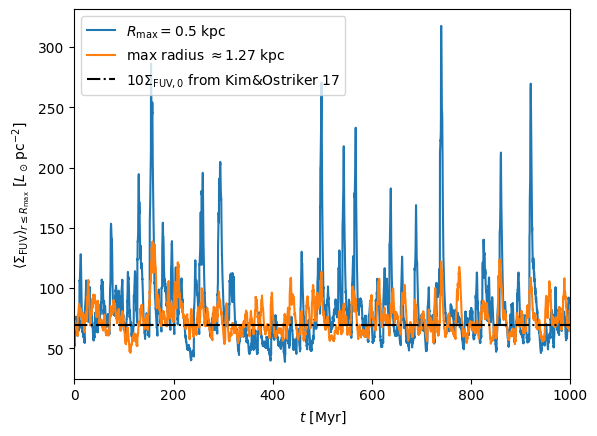

In [13]:
def measure_FUV_lum(props, times_kyr, ltom_ratio_functor, max_radius_kpc = None):
    sort_idx = np.argsort(props['age'])
    formation_t = props['age'][sort_idx]
    mass = props['mass'][sort_idx]
    radius_kpc = np.sqrt(
        np.square(props['pos_x']) +
        np.square(props['pos_y'])
    )[sort_idx]

    if max_radius_kpc is not None:
        w = (radius_kpc <= max_radius_kpc)
        formation_t = formation_t[w]
        mass = mass[w]
    
    out = np.full_like(
        times_kyr, fill_value = -np.inf, dtype='f8'
    )
    for i,t in enumerate(times_kyr):
        slc_start = np.searchsorted(formation_t, t - 40000.0, side='left')
        slc_stop = np.searchsorted(formation_t, t, side='right')
        if slc_stop < formation_t.size:
            assert formation_t[slc_stop] > t
        slc = slice(slc_start,slc_stop)
        cluster_age_kyr = t - formation_t[slc]
        specific_fuv_lum = ltom_ratio_functor(age_Myr = cluster_age_kyr/1000.0)
        out[i] = np.sum(specific_fuv_lum*mass[slc])
    return unyt.unyt_array(out, 'Lsun')


def show_FUV_lum(props, ltom_ratio_functor):

    times_kyr = np.linspace(0.0,1e6,num=10001)
    fig,ax = plt.subplots(1,1)
    times_Myr = times_kyr/1000


    for max_radius in [0.5, None]:
        if max_radius is None:
            # not so sure that the star forming radius is exactly right, double check that
            star_radius = unyt.unyt_quantity(1.27, 'kpc')
            label = r'max radius ${\approx}1.27$ kpc'
        else:
            star_radius = unyt.unyt_quantity(max_radius, 'kpc')
            label = r'$R_{\rm max}=' + str(max_radius) + r'\ {\rm kpc}$'
        area = np.pi* np.square(star_radius)

        LtotFUV = measure_FUV_lum(props, times_kyr, ltom_ratio_functor,
                                  max_radius_kpc=max_radius)
        SigmaFUV = (LtotFUV/area).to('Lsun/pc**2')
        print(max_radius, area)
        print(SigmaFUV)

        ax.plot(times_Myr, SigmaFUV,label=label)
    ax.set_xlim(times_Myr[0], times_Myr[-1])
    
    ax.axhline(69, color = 'k', ls = '-.',
               label=r"$10\Sigma_{{\rm FUV},0}$ from Kim&Ostriker 17"
               )
    ax.legend()
    
    #ax.set_yscale('log')
    ax.set_xlabel(r'$t$ [Myr]')
    ax.set_ylabel(r'$\langle\Sigma_{\rm FUV}\rangle_{r\leq R_{\rm max}}\ [L_\odot\, {\rm pc}^{-2}]$')
show_FUV_lum(props, ltom_ratio_functor)